In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    classification_report,
    accuracy_score,
    f1_score,
    confusion_matrix,
)
from sktime.split import temporal_train_test_split

# Set seaborn style
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.dpi"] = 100

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Load and Prepare Data


In [2]:
# Data path
DATA_PATH = Path("../../0_data/bissau_merged.nc")

# Center cell indices (for 5x5 grid)
CENTER_LAT_IDX = 2
CENTER_LON_IDX = 2

# Rain threshold (mm)
RAIN_THRESHOLD = 0.1

print(f"Data path: {DATA_PATH}")
print(f"Rain threshold: {RAIN_THRESHOLD} mm")

Data path: ../../0_data/bissau_merged.nc
Rain threshold: 0.1 mm


In [3]:
# Load NetCDF4 with xarray
ds = xr.open_dataset(DATA_PATH)

# Convert timestamps to datetime
time_values = pd.to_datetime(ds.valid_time.values)

# Extract center cell data & apply unit conversions
t2m_center = ds.t2m[:, CENTER_LAT_IDX, CENTER_LON_IDX].values - 273.15  # K → °C
d2m_center = ds.d2m[:, CENTER_LAT_IDX, CENTER_LON_IDX].values - 273.15  # K → °C
tcc_center = ds.tcc[:, CENTER_LAT_IDX, CENTER_LON_IDX].values * 100  # fraction → %
sp_center = ds.sp[:, CENTER_LAT_IDX, CENTER_LON_IDX].values / 100  # Pa → hPa
tp_center = ds.tp[:, CENTER_LAT_IDX, CENTER_LON_IDX].values * 1000  # m → mm

# Create DataFrame with datetime index
df = pd.DataFrame(
    {
        "datetime": time_values,
        "t2m": t2m_center,  # Temperature (°C)
        "d2m": d2m_center,  # Dewpoint (°C)
        "tcc": tcc_center,  # Cloud cover (%)
        "sp": sp_center,  # Surface pressure (hPa)
        "tp": tp_center,  # Precipitation (mm)
    }
)
df.set_index("datetime", inplace=True)


# Calculate Relative Humidity using Magnus formula
def calc_relative_humidity(t2m, d2m):
    a, b = 17.625, 243.04
    rh = 100 * np.exp((a * d2m) / (b + d2m)) / np.exp((a * t2m) / (b + t2m))
    return np.clip(rh, 0, 100)


df["rh"] = calc_relative_humidity(df["t2m"].values, df["d2m"].values)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nBasic statistics:")
df.describe().round(2)

Data shape: (18263, 6)
Date range: 1975-01-01 00:00:00 to 2024-12-31 00:00:00

Basic statistics:


,t2m,d2m,tcc,sp,tp,rh
count,18263.00,18263.00,18263.00,18263.00,18263.00,18263.00
mean,24.93,20.85,56.09,1011.19,0.10,79.89
std,1.64,4.56,40.24,1.63,0.53,16.09
min,18.62,0.08,0.00,1005.20,0.00,21.22
25%,23.99,19.05,10.79,1010.07,0.00,74.01
50%,25.13,22.68,66.50,1011.18,0.00,86.25
75%,26.07,24.03,97.31,1012.32,0.00,91.38
max,31.38,27.67,100.00,1017.49,24.93,99.86


## Correlation Heatmap

Visualize correlations between all weather variables.


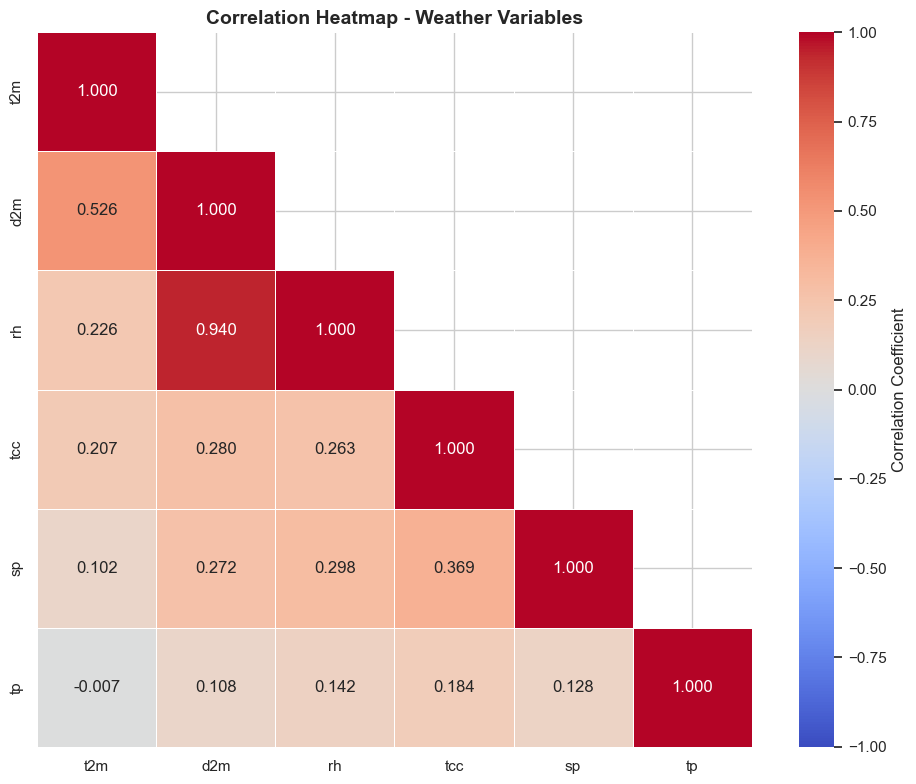


CORRELATION MATRIX SUMMARY

Temperature (°C):
  vs Dewpoint (°C)            : +0.5259
  vs Relative Humidity (%)    : +0.2257
  vs Cloud Cover (%)          : +0.2073

Dewpoint (°C):
  vs Relative Humidity (%)    : +0.9401
  vs Temperature (°C)         : +0.5259
  vs Cloud Cover (%)          : +0.2798

Relative Humidity (%):
  vs Dewpoint (°C)            : +0.9401
  vs Surface Pressure (hPa)   : +0.2977
  vs Cloud Cover (%)          : +0.2629

Cloud Cover (%):
  vs Surface Pressure (hPa)   : +0.3694
  vs Dewpoint (°C)            : +0.2798
  vs Relative Humidity (%)    : +0.2629

Surface Pressure (hPa):
  vs Cloud Cover (%)          : +0.3694
  vs Relative Humidity (%)    : +0.2977
  vs Dewpoint (°C)            : +0.2718

Precipitation (mm):
  vs Cloud Cover (%)          : +0.1842
  vs Relative Humidity (%)    : +0.1422
  vs Surface Pressure (hPa)   : +0.1283


In [4]:
# Define variables for analysis
variables = ["t2m", "d2m", "rh", "tcc", "sp", "tp"]
variable_labels = {
    "t2m": "Temperature (°C)",
    "d2m": "Dewpoint (°C)",
    "rh": "Relative Humidity (%)",
    "tcc": "Cloud Cover (%)",
    "sp": "Surface Pressure (hPa)",
    "tp": "Precipitation (mm)",
}

# Compute correlation matrix
corr_matrix = df[variables].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # Upper triangle mask
sns.heatmap(
    corr_matrix,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    mask=mask,
    square=True,
    linewidths=0.5,
    cbar_kws={"label": "Correlation Coefficient"},
)
plt.title(
    "Correlation Heatmap - Weather Variables",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

# Print correlation summary
print("\n" + "=" * 50)
print("CORRELATION MATRIX SUMMARY")
print("=" * 50)
for var in variables:
    var_corr = corr_matrix[var].drop(var).sort_values(key=abs, ascending=False)
    print(f"\n{variable_labels[var]}:")
    for other_var, corr in var_corr.head(3).items():
        print(f"  vs {variable_labels[other_var]:25s}: {corr:+.4f}")

## Scatter Matrix

Pairwise scatter plots showing relationships between all weather variables.


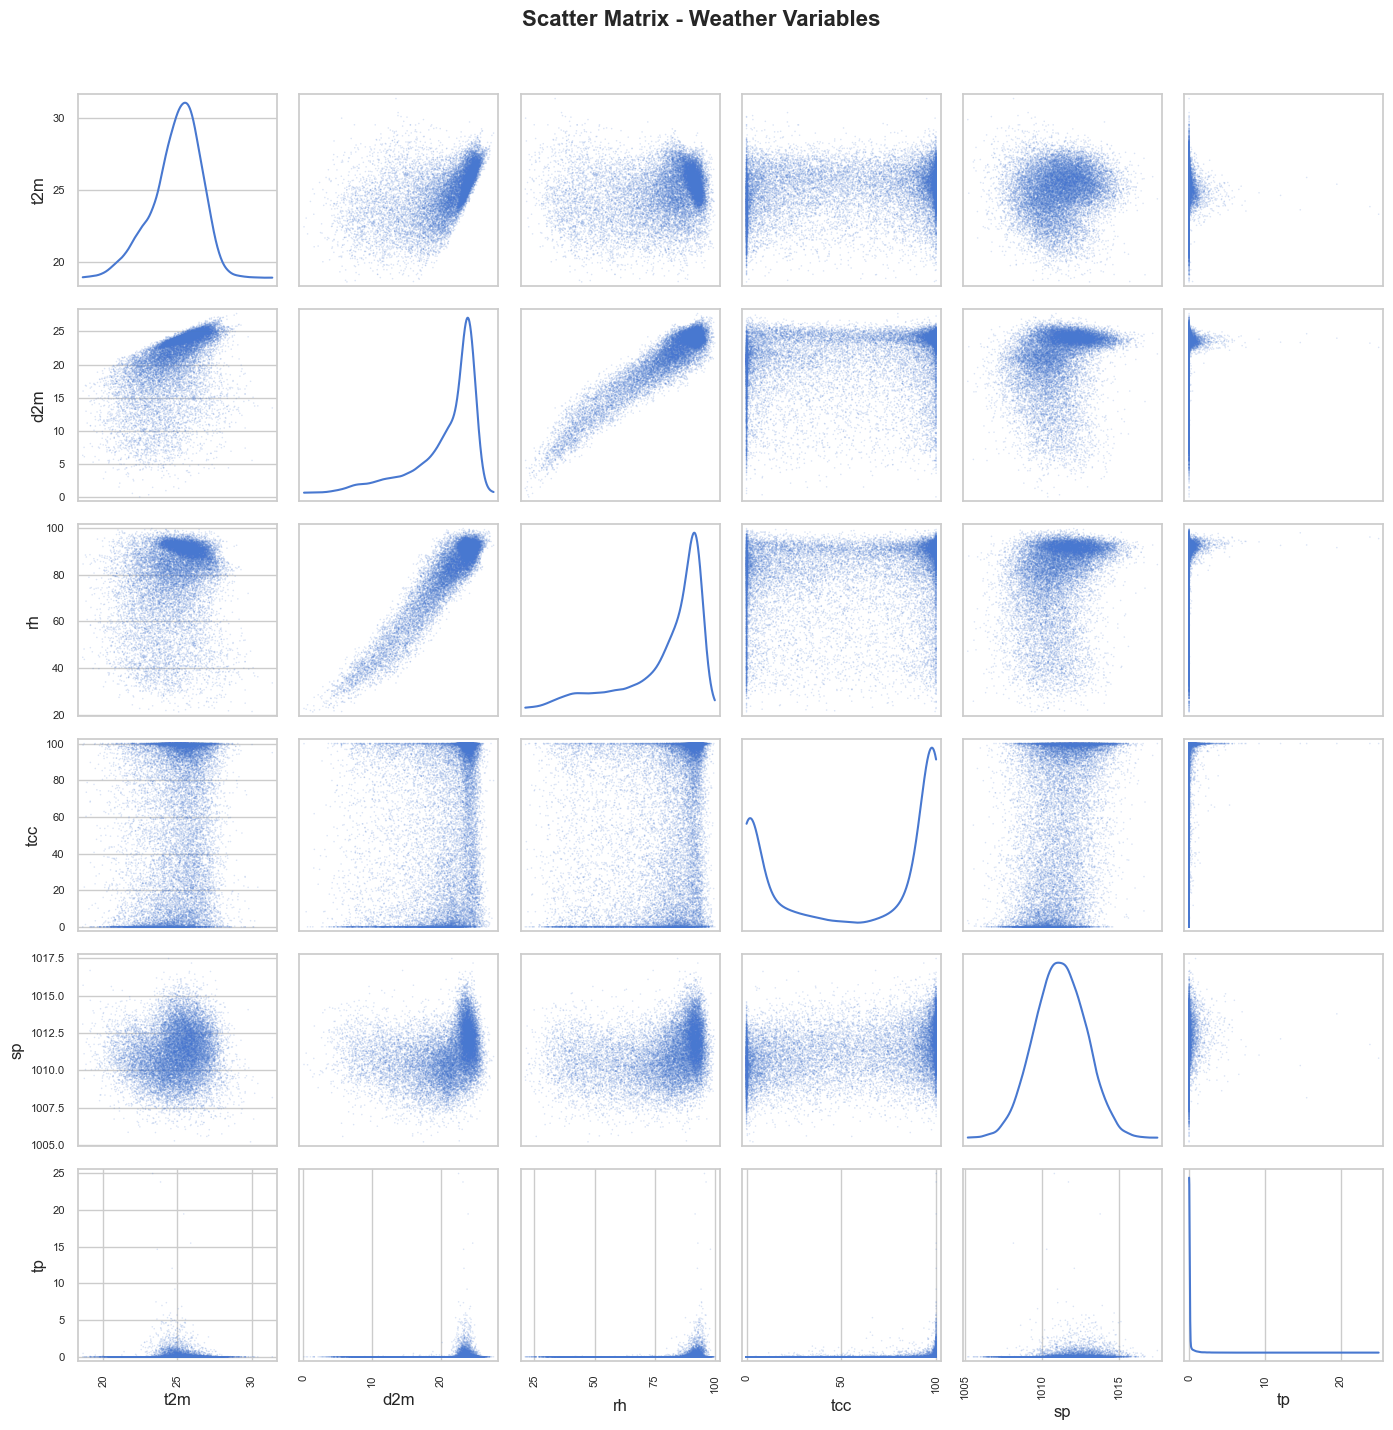

In [5]:
# Scatter matrix
fig = pd.plotting.scatter_matrix(
    df[variables], figsize=(14, 14), alpha=0.2, diagonal="kde", marker=".", s=5
)
plt.suptitle(
    "Scatter Matrix - Weather Variables",
    fontsize=16,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

## Binarize Target Variable

Create binary target: Rain (tp > 0.1mm) vs No Rain


BINARY TARGET DISTRIBUTION (threshold: 0.1 mm)

No Rain (0): 16,284 days (89.2%)
Rain (1):    1,979 days (10.8%)

Class imbalance ratio: 8.23:1


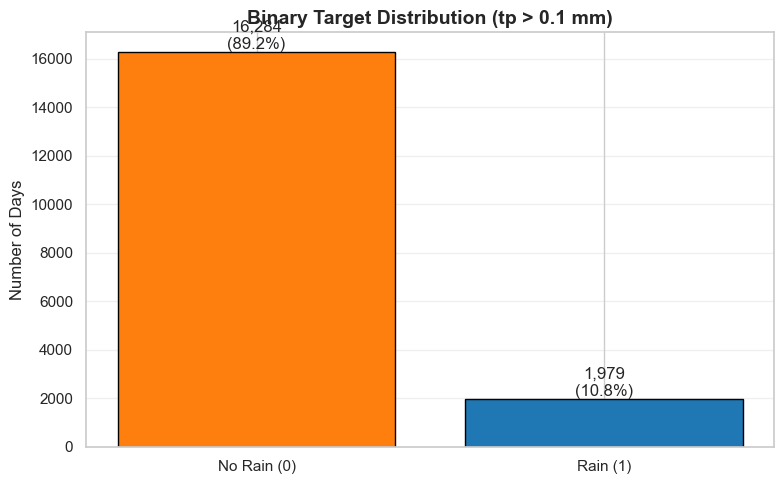

In [6]:
# Binarize precipitation: Rain vs No Rain
df["rain_binary"] = (df["tp"] > RAIN_THRESHOLD).astype(int)

# Check class distribution
class_counts = df["rain_binary"].value_counts()
class_pct = df["rain_binary"].value_counts(normalize=True) * 100

print("=" * 50)
print(f"BINARY TARGET DISTRIBUTION (threshold: {RAIN_THRESHOLD} mm)")
print("=" * 50)
print(f"\nNo Rain (0): {class_counts[0]:,} days ({class_pct[0]:.1f}%)")
print(f"Rain (1):    {class_counts[1]:,} days ({class_pct[1]:.1f}%)")
print(f"\nClass imbalance ratio: {class_counts[0]/class_counts[1]:.2f}:1")

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
colors = ["#ff7f0e", "#1f77b4"]
bars = ax.bar(
    ["No Rain (0)", "Rain (1)"], class_counts.values, color=colors, edgecolor="black"
)
ax.bar_label(
    bars,
    labels=[
        f"{c:,}\n({p:.1f}%)" for c, p in zip(class_counts.values, class_pct.values)
    ],
)
ax.set_ylabel("Number of Days")
ax.set_title(
    f"Binary Target Distribution (tp > {RAIN_THRESHOLD} mm)",
    fontsize=14,
    fontweight="bold",
)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## Feature Engineering

Add temporal features:

- Lag features (1, 2, 3, 7 days)
- Rolling statistics (7-day, 30-day mean/std)
- Lag 1 year (365 days)
- Lag 1 year rolling average


In [7]:
def create_lag_features(df, base_features, lags=[1, 2, 3, 7]):
    """Create lag features for specified columns."""
    df_feat = df.copy()
    for feat in base_features:
        for lag in lags:
            df_feat[f"{feat}_lag{lag}"] = df_feat[feat].shift(lag)
    return df_feat


def create_rolling_features(df, base_features, windows=[7, 30]):
    """Create rolling mean and std features."""
    df_feat = df.copy()
    for feat in base_features:
        for window in windows:
            df_feat[f"{feat}_rollmean{window}"] = (
                df_feat[feat].shift(1).rolling(window).mean()
            )
            df_feat[f"{feat}_rollstd{window}"] = (
                df_feat[feat].shift(1).rolling(window).std()
            )
    return df_feat


def create_yearly_lag_features(df, base_features):
    """Create lag 1 year and lag 1 year rolling average features."""
    df_feat = df.copy()
    for feat in base_features:
        # Lag 1 year (365 days)
        df_feat[f"{feat}_lag365"] = df_feat[feat].shift(365)
        # Lag 1 year rolling average (centered around same day last year)
        df_feat[f"{feat}_lag365_rollmean30"] = (
            df_feat[feat].shift(365).rolling(30, center=True).mean()
        )
    return df_feat


# Base meteorological features
# base_features = ["t2m", "d2m", "rh", "tcc", "sp"]
base_features = ["t2m", "d2m", "rh", "sp"]
# Apply feature engineering
print("Creating lag features...")
df_features = create_lag_features(df, base_features, lags=[1, 2, 3, 7])

print("Creating rolling features...")
df_features = create_rolling_features(df_features, base_features, windows=[7, 30])

print("Creating yearly lag features...")
df_features = create_yearly_lag_features(df_features, base_features)

# Add day of year for seasonality
df_features["day_of_year"] = df_features.index.dayofyear
df_features["month"] = df_features.index.month

# Drop rows with NaN (due to lagging/rolling)
df_clean = df_features.dropna()

print(f"\nOriginal shape: {df.shape}")
print(f"After feature engineering: {df_features.shape}")
print(f"After dropping NaN: {df_clean.shape}")
print(
    f"Days removed: {len(df) - len(df_clean)} (due to lag/rolling window requirements)"
)

Creating lag features...
Creating rolling features...
Creating yearly lag features...

Original shape: (18263, 7)
After feature engineering: (18263, 49)
After dropping NaN: (17869, 49)
Days removed: 394 (due to lag/rolling window requirements)


In [8]:
# Define feature columns (exclude target and original tp)
exclude_cols = ["tp", "rain_binary", "tcc", "day_of_year", "month"]
feature_columns = [col for col in df_clean.columns if col not in exclude_cols]

print(f"Total features: {len(feature_columns)}")
print(f"\nFeature categories:")
print(f"  - Base features: {len(base_features)}")
print(
    f"  - Lag features: {len([c for c in feature_columns if 'lag' in c and 'roll' not in c])}"
)
print(
    f"  - Rolling features: {len([c for c in feature_columns if 'roll' in c and 'lag365' not in c])}"
)
print(f"  - Yearly features: {len([c for c in feature_columns if 'lag365' in c])}")
print(
    f"  - Temporal features: {len([c for c in feature_columns if c in ['day_of_year', 'month']])}"
)

print(f"\nAll features:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {col}")

Total features: 44

Feature categories:
  - Base features: 4
  - Lag features: 20
  - Rolling features: 16
  - Yearly features: 8
  - Temporal features: 0

All features:
   1. t2m
   2. d2m
   3. sp
   4. rh
   5. t2m_lag1
   6. t2m_lag2
   7. t2m_lag3
   8. t2m_lag7
   9. d2m_lag1
  10. d2m_lag2
  11. d2m_lag3
  12. d2m_lag7
  13. rh_lag1
  14. rh_lag2
  15. rh_lag3
  16. rh_lag7
  17. sp_lag1
  18. sp_lag2
  19. sp_lag3
  20. sp_lag7
  21. t2m_rollmean7
  22. t2m_rollstd7
  23. t2m_rollmean30
  24. t2m_rollstd30
  25. d2m_rollmean7
  26. d2m_rollstd7
  27. d2m_rollmean30
  28. d2m_rollstd30
  29. rh_rollmean7
  30. rh_rollstd7
  31. rh_rollmean30
  32. rh_rollstd30
  33. sp_rollmean7
  34. sp_rollstd7
  35. sp_rollmean30
  36. sp_rollstd30
  37. t2m_lag365
  38. t2m_lag365_rollmean30
  39. d2m_lag365
  40. d2m_lag365_rollmean30
  41. rh_lag365
  42. rh_lag365_rollmean30
  43. sp_lag365
  44. sp_lag365_rollmean30


## Temporal Train/Val/Test Split (70/20/10)

Using sktime's `temporal_train_test_split` to preserve time ordering.


In [9]:
# Prepare X and y
X = df_clean[feature_columns]
y = df_clean["rain_binary"]

# Calculate split sizes
total = len(df_clean)
train_size = int(total * 0.70)
val_size = int(total * 0.20)
test_size = total - train_size - val_size  # Remainder (~10%)

print(f"Total samples: {total:,}")
print(f"\nPlanned split:")
print(f"  Train: {train_size:,} ({train_size/total*100:.1f}%)")
print(f"  Val:   {val_size:,} ({val_size/total*100:.1f}%)")
print(f"  Test:  {test_size:,} ({test_size/total*100:.1f}%)")

Total samples: 17,869

Planned split:
  Train: 12,508 (70.0%)
  Val:   3,573 (20.0%)
  Test:  1,788 (10.0%)


In [10]:
# First split: train vs (val + test)
y_train, y_temp = temporal_train_test_split(y, test_size=(val_size + test_size))
X_train, X_temp = temporal_train_test_split(X, test_size=(val_size + test_size))

# Second split: val vs test
y_val, y_test = temporal_train_test_split(y_temp, test_size=test_size)
X_val, X_test = temporal_train_test_split(X_temp, test_size=test_size)

print("=" * 60)
print("TEMPORAL SPLIT RESULTS")
print("=" * 60)
print(f"\nTrain set: {len(X_train):,} samples ({len(X_train)/total*100:.1f}%)")
print(f"  Date range: {X_train.index.min().date()} to {X_train.index.max().date()}")
print(f"  Rain days: {y_train.sum():,} ({y_train.mean()*100:.1f}%)")

print(f"\nValidation set: {len(X_val):,} samples ({len(X_val)/total*100:.1f}%)")
print(f"  Date range: {X_val.index.min().date()} to {X_val.index.max().date()}")
print(f"  Rain days: {y_val.sum():,} ({y_val.mean()*100:.1f}%)")

print(f"\nTest set: {len(X_test):,} samples ({len(X_test)/total*100:.1f}%)")
print(f"  Date range: {X_test.index.min().date()} to {X_test.index.max().date()}")
print(f"  Rain days: {y_test.sum():,} ({y_test.mean()*100:.1f}%)")

TEMPORAL SPLIT RESULTS

Train set: 12,508 samples (70.0%)
  Date range: 1976-01-16 to 2010-04-14
  Rain days: 1,333 (10.7%)

Validation set: 3,573 samples (20.0%)
  Date range: 2010-04-15 to 2020-01-25
  Rain days: 365 (10.2%)

Test set: 1,788 samples (10.0%)
  Date range: 2020-01-26 to 2024-12-17
  Rain days: 226 (12.6%)


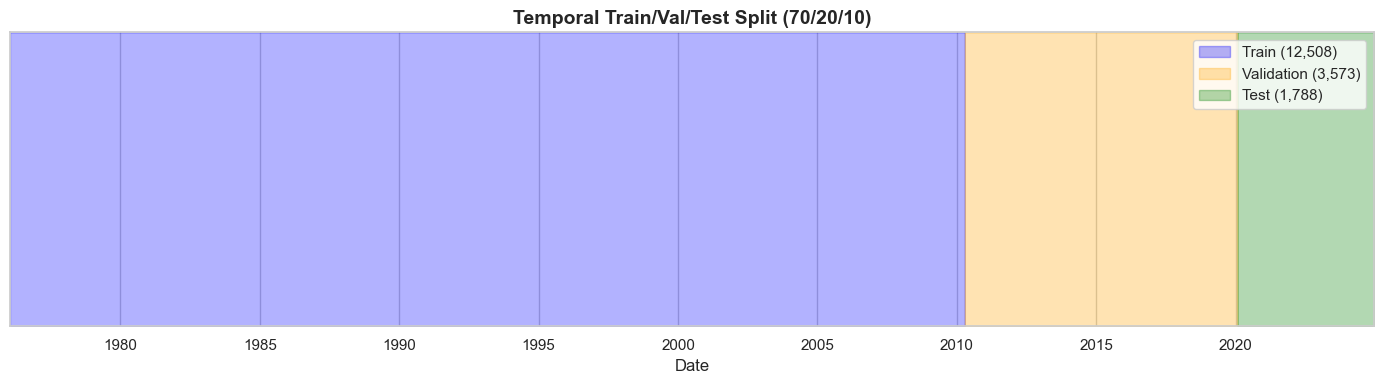

In [11]:
# Visualize the split
fig, ax = plt.subplots(figsize=(14, 4))

ax.fill_between(
    X_train.index, 0, 1, alpha=0.3, color="blue", label=f"Train ({len(X_train):,})"
)
ax.fill_between(
    X_val.index, 0, 1, alpha=0.3, color="orange", label=f"Validation ({len(X_val):,})"
)
ax.fill_between(
    X_test.index, 0, 1, alpha=0.3, color="green", label=f"Test ({len(X_test):,})"
)

ax.set_xlim(df_clean.index.min(), df_clean.index.max())
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.set_xlabel("Date")
ax.set_title("Temporal Train/Val/Test Split (70/20/10)", fontsize=14, fontweight="bold")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

## Logistic Regression Model

Train a logistic regression classifier with balanced class weights.


In [12]:
# Create pipeline with StandardScaler and Logistic Regression
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "model",
            LogisticRegression(
                max_iter=1000, class_weight="balanced", random_state=42, solver="lbfgs"
            ),
        ),
    ]
)

print("Training Logistic Regression with balanced weights...")
pipe.fit(X_train, y_train)
print("Training complete!")

Training Logistic Regression with balanced weights...
Training complete!


In [13]:
# Predictions
y_train_pred = pipe.predict(X_train)
y_train_proba = pipe.predict_proba(X_train)[:, 1]

y_val_pred = pipe.predict(X_val)
y_val_proba = pipe.predict_proba(X_val)[:, 1]

y_test_pred = pipe.predict(X_test)
y_test_proba = pipe.predict_proba(X_test)[:, 1]

# Calculate metrics
train_auc = roc_auc_score(y_train, y_train_proba)
train_acc = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

val_auc = roc_auc_score(y_val, y_val_proba)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

test_auc = roc_auc_score(y_test, y_test_proba)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("=" * 60)
print("LOGISTIC REGRESSION RESULTS (Balanced Weights)")
print("=" * 60)
print(f"\n{'Set':<12} {'Accuracy':>10} {'F1 Score':>10} {'ROC AUC':>10}")
print("-" * 45)
print(f"{'Train':<12} {train_acc:>10.4f} {train_f1:>10.4f} {train_auc:>10.4f}")
print(f"{'Validation':<12} {val_acc:>10.4f} {val_f1:>10.4f} {val_auc:>10.4f}")
print(f"{'Test':<12} {test_acc:>10.4f} {test_f1:>10.4f} {test_auc:>10.4f}")

LOGISTIC REGRESSION RESULTS (Balanced Weights)

Set            Accuracy   F1 Score    ROC AUC
---------------------------------------------
Train            0.7835     0.4690     0.9041
Validation       0.7940     0.4697     0.9053
Test             0.8473     0.5882     0.9198


In [14]:
# Classification reports
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT - VALIDATION SET")
print("=" * 60)
print(
    classification_report(y_val, y_val_pred, target_names=["No Rain (0)", "Rain (1)"])
)

print("\n" + "=" * 60)
print("CLASSIFICATION REPORT - TEST SET")
print("=" * 60)
print(
    classification_report(y_test, y_test_pred, target_names=["No Rain (0)", "Rain (1)"])
)


CLASSIFICATION REPORT - VALIDATION SET
              precision    recall  f1-score   support

 No Rain (0)       0.98      0.78      0.87      3208
    Rain (1)       0.32      0.89      0.47       365

    accuracy                           0.79      3573
   macro avg       0.65      0.84      0.67      3573
weighted avg       0.92      0.79      0.83      3573


CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

 No Rain (0)       0.98      0.85      0.91      1562
    Rain (1)       0.45      0.86      0.59       226

    accuracy                           0.85      1788
   macro avg       0.71      0.85      0.75      1788
weighted avg       0.91      0.85      0.87      1788



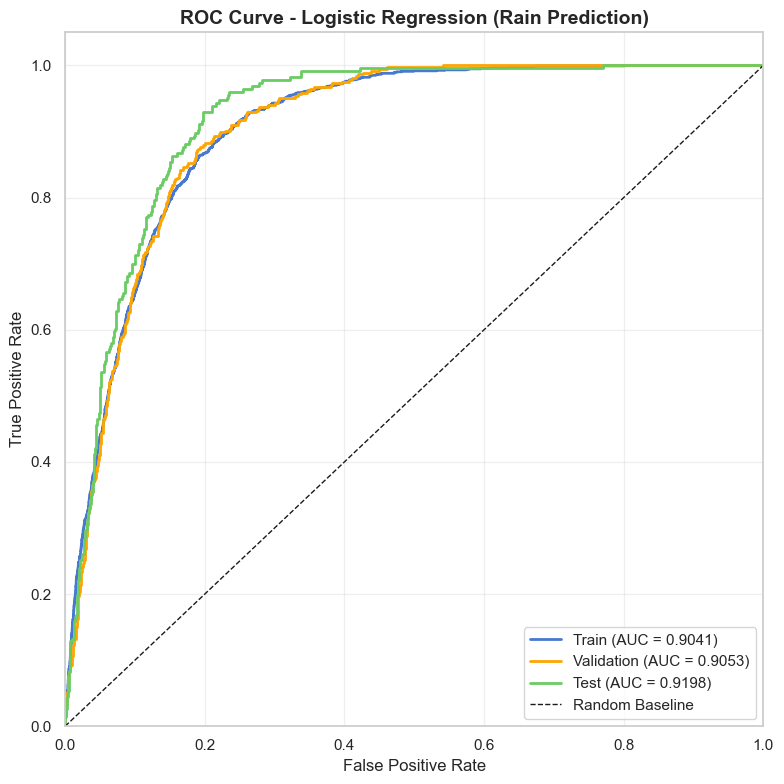

In [15]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(8, 8))

# Train ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
ax.plot(fpr_train, tpr_train, "b-", lw=2, label=f"Train (AUC = {train_auc:.4f})")

# Validation ROC
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
ax.plot(fpr_val, tpr_val, "orange", lw=2, label=f"Validation (AUC = {val_auc:.4f})")

# Test ROC
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
ax.plot(fpr_test, tpr_test, "g-", lw=2, label=f"Test (AUC = {test_auc:.4f})")

# Random baseline
ax.plot([0, 1], [0, 1], "k--", lw=1, label="Random Baseline")

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title(
    "ROC Curve - Logistic Regression (Rain Prediction)", fontsize=14, fontweight="bold"
)
ax.legend(loc="lower right")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

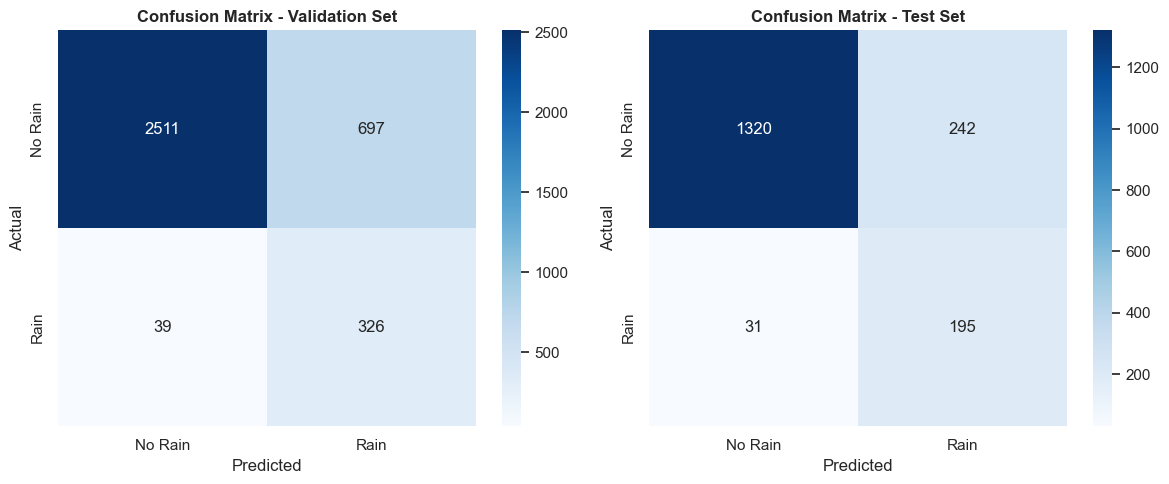

In [16]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (y_true, y_pred_set, title) in zip(
    axes, [(y_val, y_val_pred, "Validation"), (y_test, y_test_pred, "Test")]
):
    cm = confusion_matrix(y_true, y_pred_set)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax,
        xticklabels=["No Rain", "Rain"],
        yticklabels=["No Rain", "Rain"],
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"Confusion Matrix - {title} Set", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

## Feature Importance

Analyze which features are most important for predicting rain.


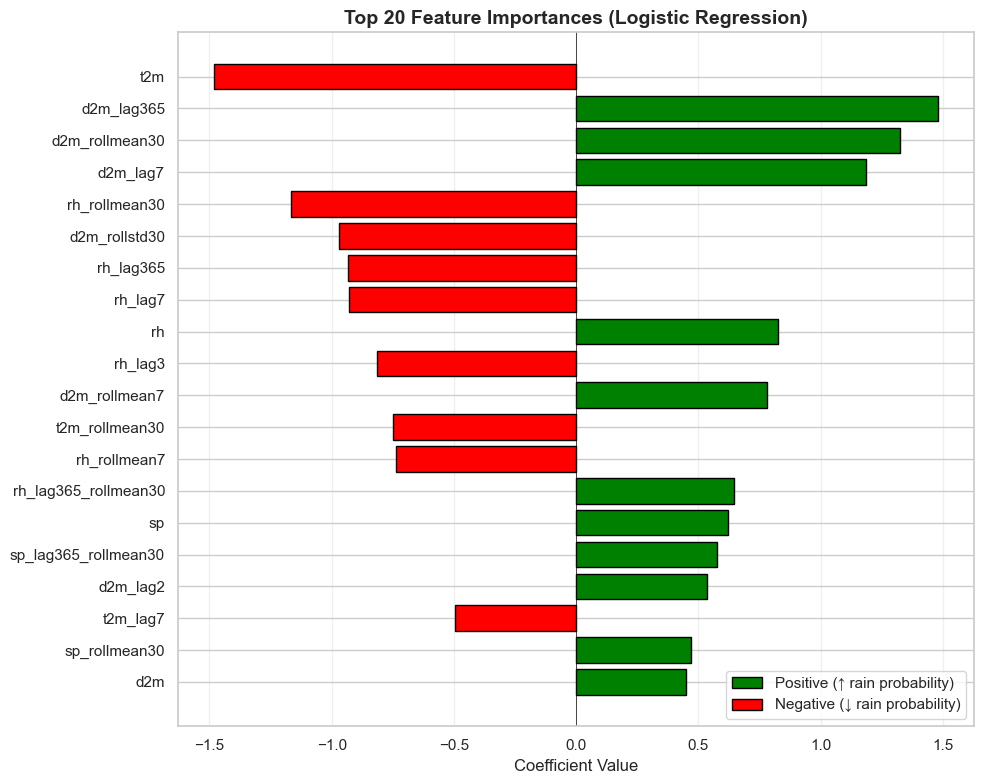


Top 10 most important features:
       feature  coefficient
           t2m    -1.479446
    d2m_lag365     1.478896
d2m_rollmean30     1.322220
      d2m_lag7     1.183101
 rh_rollmean30    -1.166497
 d2m_rollstd30    -0.971663
     rh_lag365    -0.932951
       rh_lag7    -0.929139
            rh     0.824276
       rh_lag3    -0.814738


In [17]:
# Get feature importances (absolute coefficients)
coefficients = pipe.named_steps["model"].coef_[0]
feature_importance = pd.DataFrame(
    {
        "feature": feature_columns,
        "coefficient": coefficients,
        "abs_coefficient": np.abs(coefficients),
    }
).sort_values("abs_coefficient", ascending=False)

# Plot top 20 features
top_n = 20
fig, ax = plt.subplots(figsize=(10, 8))

top_features = feature_importance.head(top_n)
colors = ["green" if c > 0 else "red" for c in top_features["coefficient"]]

ax.barh(
    range(len(top_features)),
    top_features["coefficient"],
    color=colors,
    edgecolor="black",
)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features["feature"])
ax.invert_yaxis()
ax.set_xlabel("Coefficient Value")
ax.set_title(
    f"Top {top_n} Feature Importances (Logistic Regression)",
    fontsize=14,
    fontweight="bold",
)
ax.axvline(x=0, color="black", linestyle="-", linewidth=0.5)
ax.grid(axis="x", alpha=0.3)

# Add legend
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor="green", edgecolor="black", label="Positive (↑ rain probability)"),
    Patch(facecolor="red", edgecolor="black", label="Negative (↓ rain probability)"),
]
ax.legend(handles=legend_elements, loc="lower right")

plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(feature_importance[["feature", "coefficient"]].head(10).to_string(index=False))

## Summary


In [18]:
print("=" * 70)
print("PRECIPITATION PREDICTION MODEL SUMMARY")
print("=" * 70)
print(f"\nData:")
print(f"  Source: ERA5 Reanalysis - Bissau, Guinea-Bissau")
print(f"  Period: {df_clean.index.min().date()} to {df_clean.index.max().date()}")
print(f"  Total samples: {len(df_clean):,} days")

print(f"\nTarget Variable:")
print(f"  Binary classification: Rain (tp > {RAIN_THRESHOLD} mm) vs No Rain")
print(f"  Class distribution: {df_clean['rain_binary'].mean()*100:.1f}% rain days")

print(f"\nFeatures: {len(feature_columns)} total")
print(f"  - Base meteorological: t2m, d2m, rh, tcc, sp")
print(f"  - Lag features: 1, 2, 3, 7 days")
print(f"  - Rolling statistics: 7-day and 30-day mean/std")
print(f"  - Yearly features: lag 365 days, lag 365 rolling mean")
print(f"  - Temporal: day_of_year, month")

print(f"\nModel: Logistic Regression")
print(f"  - Class weight: balanced")
print(f"  - Preprocessing: StandardScaler")

print(f"\nResults:")
print(f"  {'Set':<12} {'Accuracy':>10} {'F1 Score':>10} {'ROC AUC':>10}")
print(f"  {'-'*45}")
print(f"  {'Train':<12} {train_acc:>10.4f} {train_f1:>10.4f} {train_auc:>10.4f}")
print(f"  {'Validation':<12} {val_acc:>10.4f} {val_f1:>10.4f} {val_auc:>10.4f}")
print(f"  {'Test':<12} {test_acc:>10.4f} {test_f1:>10.4f} {test_auc:>10.4f}")

PRECIPITATION PREDICTION MODEL SUMMARY

Data:
  Source: ERA5 Reanalysis - Bissau, Guinea-Bissau
  Period: 1976-01-16 to 2024-12-17
  Total samples: 17,869 days

Target Variable:
  Binary classification: Rain (tp > 0.1 mm) vs No Rain
  Class distribution: 10.8% rain days

Features: 44 total
  - Base meteorological: t2m, d2m, rh, tcc, sp
  - Lag features: 1, 2, 3, 7 days
  - Rolling statistics: 7-day and 30-day mean/std
  - Yearly features: lag 365 days, lag 365 rolling mean
  - Temporal: day_of_year, month

Model: Logistic Regression
  - Class weight: balanced
  - Preprocessing: StandardScaler

Results:
  Set            Accuracy   F1 Score    ROC AUC
  ---------------------------------------------
  Train            0.7835     0.4690     0.9041
  Validation       0.7940     0.4697     0.9053
  Test             0.8473     0.5882     0.9198
